# Introdution 

The notebook is a behind-the-scenes look at the data wrangling behind the story on *The Urbanizational Evolution of New York City - From Seed to Apple* presented on https://esbenbl.github.io/


The structure of the notebook is:
1. [Motivation](#Motivation)
2. [Basic Statistics](#base_stats)
    - [Dataset of the buildings of New York City](#Dataset_of_the_buildings)
    - [Dataset of the population evolution of New York](#Dataset_of_the_population)
    - [Dataset on ethnicity population in NYC neighboorhoods between 20XX and 2020](Dataset_ethnicitiy)
3. [Data Analysis](#Data_Analysis)
4. [Genre](#Genre)
5. [Visualization](#Visualization)
6. [Discussion](#Discussion)
7. [Contribution](#Controbution)
8. [References](#References)

To run the notebook you need to load the packages in the next section

In [1]:
# Packages for this notebook
import geopandas as gpd
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["font.family"] = "Garamond"
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import folium 
from folium import plugins

# Motivation <a id="Motivation"></a>
- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?


New York is one of the most renowned and global metropolises in the world, some even call it the Capital of the World. In the 19th century due to waves of immigration and industrialization the city's population exploded, also transforming New York. The transformation of New York City’s physical, social and cultural landscape during the 19th time period shaped the cities identity and influenced the development of urban planning, transportation and social policies that continue to shape the city's urban fabric today. Studying the evolution of New York City's urbanization thus provides a rich historical context for understanding contemporary urban challenges and opportunities, making it an interesting and relevant subject for examination. 

We will examine New York's urbanization through data from NYC Department of City Planning, where we will combine two datasets from the department. The first dataset is of the 800.000 buildings in New York and their placement, and the second shows the characteristics of the land use and geographic data which the buildings are built upon. Thus we get a full dataset on both the year of each individual building as well as the type of building, eg. is it commercial or residential. Furthermore we also consider including more data on neighborhood level from New york maybe regarding the overall evolution of other parameters in New York's neighborhoods such as, crime, income, education, or the overall evolution of the metropolis such as subways, schools, hospitals.  etc. 

# Basic Statistics <a id="base_stats"></a>
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In this project we use multiple datasets as to get the most nuanced and representative data on New York cities evolution through time with focus on the segregation and migration development. (SKAL LIGE SKRIVES UD OG TIL I FORHOLD TIL INDLEDNING). 
In this project we use a total of X amount of datasets, gathered from multiple different US government institutions. Merging and combining the datasets we end up with a total of X final datasets. This section is structured by these final datasets and explain the making of each of them aswell as present their final statistics.  

### Dataset of the buildings of New York <a id="Dataset_of_the_buildings"></a>

## Overvejelser til afsnit: 
    - Skal vi også præsentere GeoJson dataset for NYC her, eller skal man måske gøre det endnu mere i starten? 
    - Der var vidst noget med at der er nogle grupperinger hvert 5 år, følg lige op det. 
    - Der skal måske også noget ind her omkring det industrielle? 

Our dataset of the buildings and the related plot of land is essential for our initial analysis and illustration of New York Cities evolution throughout time. This dataset is a combination of two datasets: One dataset from [City of New York](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh) on the building footprints of New York, and another dataset from [NYC Planning](https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). In the following code we load, clean, and merge the two datasets. 

In [42]:
## Loading the two datasets

# Building footprints from https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
# Documentation https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md
building_footprints = gpd.read_file("Exam_datasets/Building_Footprints.geojson") 

# NYC Borough GeoJson
new_york_boroughs_map = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-city-boroughs.geojson")

# PLUTO Data from https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
columns_subset = ["borough","cd", "latitude", "longitude", 'landuse', "assesstot", "numbldgs",
                  "numfloors", "unitstotal", "bldgarea", "comarea", "resarea", "bbl"]
land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]

C:\Users\asger\AppData\Local\Temp\ipykernel_5780\2059624798.py:13: DtypeWarning: Columns (21,22,24,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use_dataaset = pd.read_csv("Exam_datasets/pluto_22v3_1.csv")[columns_subset]


##### Cleaning BUILDING FOOTPRINTS

In [43]:
# remove missing construction_years
building_footprints = building_footprints[-pd.isna(building_footprints.cnstrct_yr)].copy() 

# To int 
building_footprints.cnstrct_yr = building_footprints.cnstrct_yr.astype("int64")

# Construct bins 
ten_year_bins = [0]+[year for year in range(1899,2029,10)]+[2030]
ten_year_labels = ["Before 1900"] + [str(year)+"s" for year in range(1900,2020,10)] + ["2020s"]

# Into Bins
building_footprints["cnstrct_yr_intervals"] = pd.cut(building_footprints.cnstrct_yr, bins = ten_year_bins, labels = ten_year_labels)

# Align BBL with PLUTOs datatypes 
building_footprints = building_footprints.rename(columns = {"mpluto_bbl":"bbl"})
building_footprints.bbl = building_footprints.bbl.astype("int64")

# Distinguish geometry  
building_footprints["building_geometry"] = building_footprints.geometry.copy()

##### Cleaning PLUTO land use data 

In [44]:
# drop nan for PLUTO
land_use_dataaset = land_use_dataaset.dropna().copy() # drop na 
land_use_dataaset.bbl = land_use_dataaset.bbl.astype("int64") # to int 

# Dicts to convert values  
landuse_key = {1:"One & Two Family Building",
                2:"Multi-Family Walk-Up Buildings",
                3:"Multi-Family Elevator Buildings",
                4:"Mixed Residential & Commercial Buildings",
                5:"Commerical & Office Buildings",
                6:"Industrial & Manufacturing Buildings",
                7:"Transportation & Utility",
                8:"Public Facilities & Institutions",
                9:"Open Space & Outdoor Recreation",
                10: "Parking Facilities",
                11:"Vacant Land"}

borough_key = {"BK":"Brooklyn",
               "QN":"Queens",
               "MN":"Manhattan",
               "BX":"Bronx",
               "SI":"Staten Island"}

# Map dicts
land_use_dataaset.borough = land_use_dataaset.borough.apply(lambda x: borough_key[x])
land_use_dataaset["landuse_label"] =  land_use_dataaset.landuse.apply(lambda x: landuse_key[x])

##### Merge Building Footprints and PLUTO datasets

In [45]:
buildings_and_landuse = pd.merge(building_footprints, land_use_dataaset, on = "bbl", how = "outer", indicator = True)

In [46]:
print("Total amount of unique buildings in the dataset: {}".format(len(buildings_and_landuse)))
print("Total amount of unique land plots: {}".format(buildings_and_landuse["bbl"].nunique()))
print("The dataset has {} columns".format(len(buildings_and_landuse.columns)))

Total amount of unique buildings in the dataset: 1089896
Total amount of unique land plots: 817842
The dataset has 31 columns


We combine the two dataset based on BBL column which stand for "borough, block and lot", merging on this variabe makes it possible to combine our data on buildings with our data on land lots.Before cleaning the dataset consists of 31 columns with a total of 10.898.686 buildings and a total 817.842 unique land plots. But this is not the final data, as we first do a sanity check of the merge and check how many BBL values from each of the two datasets does not exist in the other. 

#### Sanity check on merge between Buildings and land plots

In [52]:
# We construct two explorative datasets to explore how many buildings which only exist in one of the two datasets
only_in_building_footprints = buildings_and_landuse.query("_merge == 'left_only'")
only_in_pluto = buildings_and_landuse.query("_merge == 'right_only'")

print(f"Buildings not found in Building Footprint: {only_in_pluto.shape[0]}")
print(f"Buildings not found in PLUTO: {only_in_building_footprints.shape[0]}")

Buildings not found in Building Footprint: 6033
Buildings not found in PLUTO: 14410


With a dataset consisting of a total of 10.898.686 observations, some missing values seems to be unavoidable. Looking into the amount of missing values we have a total of 20.443 missing values which correspond to 0.2 percent of the total dataset. We think this is rather low, but even a low amount of missing values can be a problem if biased towards a certain group or category, therefore we will look into the distribution of the missing values.

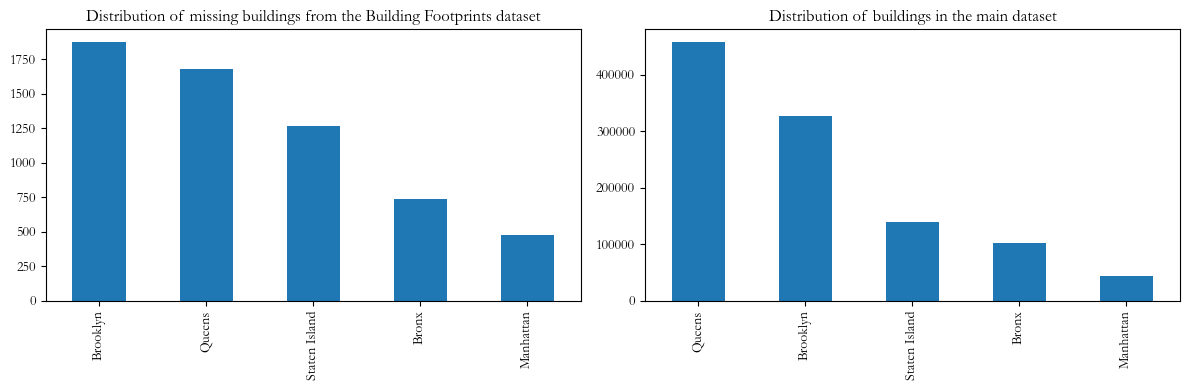

In [64]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot the first bar plot onto the first subplot
only_in_pluto.borough.value_counts().plot.bar(title="Distribution of missing buildings from the Building Footprints dataset", ax=ax1)

# Plot the second bar plot onto the second subplot
buildings_and_landuse.borough.value_counts().plot.bar(title="Distribution of buildings in the main dataset", ax=ax2)

# Set a common y-axis label for both subplots
#fig.text(0.04, 0.5, va='center', rotation='vertical')

# Display the plot
plt.tight_layout()
plt.show()

The Building Footprints data has a total of 6.033 missing values. We look into into the distribution of these missing values among the five boroughs of NYC, and conclude that the overall distribution of missing values look rather evenly spread. It is apparent that Queens and Brooklyn is the boroughs with the highest amount of missing values, but this shows an unbias distribution of missing values as these two also are the boroughs with the overall highest amount of buildings.   

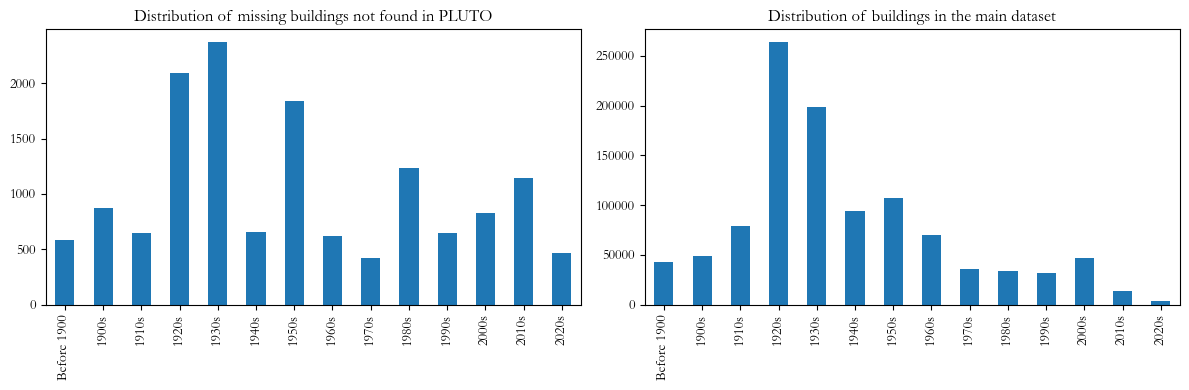

In [65]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot the first bar plot onto the first subplot
only_in_building_footprints.cnstrct_yr_intervals.value_counts().sort_index().plot.bar(title = "Distribution of missing buildings not found in PLUTO", ax=ax1)

# Plot the second bar plot onto the second subplot
buildings_and_landuse.cnstrct_yr_intervals.value_counts().sort_index().plot.bar(title = "Distribution of buildings in the main dataset", ax=ax2)

# Set a common y-axis label for both subplots
#fig.text(0.04, 0.5, va='center', rotation='vertical')

# Display the plot
plt.tight_layout()
plt.show()

The PLUTO data has a total of 14.410 missing values. We look into into the distribution of these missing values over the years, and also conclude that the overall distribution of missing values look rather evenly spread. It is apparent that the two years with the highest amount of missing values also is the years with the highest amount of buildings being build.

In [58]:
buildings_and_landuse = buildings_and_landuse.query("_merge == 'both'").copy()
buildings_and_landuse.cnstrct_yr = buildings_and_landuse.cnstrct_yr.astype("int64")
# Dimensions of dataset 
buildings_and_landuse.shape

(1069453, 31)

This has been a presentation of one of the three essential datasets used in this project, the buildings and land use dataset. We have explained the overall dataset, and argue that the amount of missing data when combining the two datasets is miniscule and unbiased. After cleaning and merging the overall dataset we have a datasaet containing 31 columns with 1.069.453 rows of unique buildings and their related landplot.  

### Dataset of the population evolution of New York<a id="Dataset_of_the_population"></a>

Besides our dataset of the buildings of NYC, another essential part of our analysis is the population evolution of NYC. To further examine the development of the migration and over poplation movements of NYC, we have used data from [the official website of NYC](https://www.nyc.gov/). We have used two dataset from this website, [one on the overall population development](https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_total_pop_1900-2010.xlsx) and [one on the development of the foreign born population](https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_fb_pop_1900-2010.xlsx). Both datasets are rather similar, with the first one containing the overall population numbers for each NYC borough each decade, and the second containing the amount of foreing born population in each NYC borough each decade.

(SKAL MÅSKE STÅ SIDST I AFSNITTET, DET KAN GODT VÆRE DET SIDSTE HER SKAL SKRIVES LIDT SKARPERE)
Because of the simplicity of both datasets their is not that much cleaning or manipulation to take care of since both datasets consists of 12 rows and 7 columns. The construction of the datasets seems to have been a rather complicated endeavour with combinations of data form multiple sources, and it would probably be possible to write a full data science project regarding the composition of the datasets which presents exact population numbers for each decade for a 110 year period. We decide to trust the NYC government and the data legibility, but one would like to scrutinise this decision it would be possible to start going through the sources used for each dataset her: [documentation for population development](https://www.nyc.gov/assets/planning/download/pdf/planning-level/nyc-population/historical-population/nyc_total_pop_1900-2010.pdf) and [documentation for foreign born population development](https://www.nyc.gov/assets/planning/download/pdf/planning-level/nyc-population/historical-population/nyc_fb_pop_1900-2010.pdf)

##### Loading and preparing the datasets

In [74]:
# Loading population by borough dataset
population_by_borough = pd.read_excel("https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_total_pop_1900-2010.xlsx", skiprows = 3, index_col = 0)
population_by_borough = population_by_borough.dropna().reset_index(names = ["decade"])

# Loading foreing born population by borough dataset
foreign_born_pop = pd.read_excel("https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_fb_pop_1900-2010.xlsx", skiprows = 3, index_col = 0)
foreign_born_pop = foreign_born_pop.dropna().reset_index(names = ["decade"])
foreign_born_pop.decade = foreign_born_pop.decade.apply(lambda x: str(x).replace("*","")).astype(int)
foreign_born_pop = foreign_born_pop.set_index("decade")

# Combining the two datasets to show the share of foreign born by boruogh
share_of_foreign_born_by_decade = foreign_born_pop / population_by_borough.loc[1900:2010] * 100
share_of_foreign_born_by_decade = share_of_foreign_born_by_decade.drop("New York City", axis =1 )

### Dataset on ethnicity population in NYC neighboorhoods between 20XX and 2020  <a id="Dataset_ethnicitiy"></a>

# Data Analysis <a id="Data_Analysis"></a>
- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.

# Genre <a id="Genre"></a>
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

Overall our website and data story structure will be rather linear, structured, with most in common with the magazine visualization genre described by Segel and Heer. But as we also are concerned with keeping the reader active and engaged, we will also incorporate interactive plots in which the reader can explore and engage within the frames of our data story and magazine style, thus if a reader for example have an interest in a specific neighborhood in New York it will be possible to specifically mouse over that and see that neighborhoods data. 

# Visualizations<a id="Visualizations"></a>
- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?

# Discussion<a id="Discussion"></a>
- What went well?,
- What is still missing? What could be improved?, Why?

# Contributions<a id="Contributions"></a>
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
- It is not OK simply to write "All group members contributed equally".

# References <a id="References"></a>
- Make sure that you use references when they're needed and follow academic standards.

# Datasets

- Building footprints, [City of New York](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh)
- PLUTO data, [NYC Planning](https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)
- [The overall population development of NYC's boroughs](https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_total_pop_1900-2010.xlsx) 
- [The overall development of the foreign born population of NYC's boroughs](https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/historical-population/nyc_fb_pop_1900-2010.xlsx)